# Analysis and Evaluation of different Machine Learning Algorithms on big data

**Author: Sin Yee Neo**

Date: 31/01/2021

Environment: Python 3.6.0

## 1 Data Loading and Exploration
### 1.1 Data Loading
#### 1.1) 1. Create SparkSession
Create `SparkSession` to use `SparkConf` object to configure the Spark app with the setting as follow:

* Application name: Pedestrain Traffic Prediction
* Session timezone: UTC
* run with all working processors

In [5]:
# import library
from pyspark import SparkConf
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
from datetime import datetime
from pyspark.sql.functions import to_timestamp, col, udf
from pyspark.sql.types import DateType
from pyspark.sql import functions as f
from pyspark.sql import Row
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import countDistinct, avg, stddev
from pyspark.sql.functions import to_date, month
from pyspark.sql.types import StructType, IntegerType, TimestampType,StringType,DateType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.regression import DecisionTreeRegressor, GBTRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import lit
from pyspark.ml import PipelineModel
from pyspark.sql.functions import when
from pyspark.sql.window import Window
import pyspark.sql.functions as func
from scipy.stats import chi2_contingency
from pyspark.ml.linalg import Vectors

In [6]:
# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
master = "local[*]"

# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Pedestrain Traffic Analysis"

#### set melbourne timezone

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
spark.conf.set("spark.sql.session.timeZone", 'UTC')


sc = spark.sparkContext
sc.setLogLevel('ERROR')

In [7]:
# Read files into dataframes
df_pedcount = spark.read.csv("Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv", header=True, inferSchema= True)
df_senloc = spark.read.csv("Pedestrian_Counting_System_-_Sensor_Locations.csv", header=True, inferSchema= True)

In [8]:
# Data Schema
df_pedcount.printSchema()
df_senloc.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: string (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)



In [9]:
plt1 = df_pedcount.select('*')
plt2 = df_pedcount.select('*')

In [10]:
schema_A = StructType() \
      .add("ID",IntegerType(),True) \
      .add("Date_Time",StringType(),True) \
      .add("Year",IntegerType(),True) \
      .add("Month",StringType(),True) \
      .add("Mdate",IntegerType(),True) \
      .add("day",StringType(),True) \
      .add("Time",IntegerType(),True) \
      .add("Sensor_ID",IntegerType(),True) \
      .add("Sensor_Name",StringType(),True) \
      .add("Hourly_Counts",IntegerType(),True)

In [11]:
schema_B = StructType() \
      .add("sensor_id",IntegerType(),True) \
      .add("sensor_description",StringType(),True) \
      .add("sensor_name",StringType(),True) \
      .add("installation_date",DateType(),True) \
      .add("status",StringType(),True) \
      .add("note",StringType(),True) \
      .add("direction_1",StringType(),True) \
      .add("direction_2",StringType(),True) \
      .add("latitude",StringType(),True)

In [12]:
# Load the pedestrian count and sensor location file into a dataframe
df_pedcount = spark.read.options(header = 'True', delimiter=',').schema(schema_A) \
  .csv("Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv")

df_senloc = spark.read.options(header = 'True', delimiter=',').schema(schema_B) \
  .csv("Pedestrian_Counting_System_-_Sensor_Locations.csv")

In [13]:
df_pedcount.printSchema()
df_senloc.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: date (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: string (nullable = true)



In [14]:
df_pedcount = df_pedcount.withColumn('Date_Time', to_timestamp(df_pedcount.Date_Time, 'MM/dd/yyyy hh:mm:ss a'))

In [15]:
# Data Schema
df_pedcount.printSchema()
df_senloc.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: date (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: string (nullable = true)



#### 1.1) 4. Create threshold column
Create a new column in the pedestrain count dataFrame - <span style="color: blue;">df_pedcount</span> and named it as <span style="color: green;">above_threshold</span>. The new column is to indicate whether the hourly count is above 2000 or below. 
 - Label **0** for count < 2000
 - Label **1** for count => 2000

In [16]:
# Add threshold column
df_pedcount = df_pedcount.withColumn('above_threshold', f.when(f.col('Hourly_Counts') < 2000, 0).otherwise(1))

### 1.2 Exploring the data
#### 1.2) 1 Summary Statistic
Show basic statistics for each numeric column except <span style="color: green;">above_threshold</span> and <span style="color: green;">Date_Time</span>. Basic statistic to be shown:

* count
* mean
* stddev
* min
* 25 percentile
* 50 percentile
* 75 percentile

In [17]:
#Summary Statistics
statistic = df_pedcount.select([c for c in df_pedcount.columns if c not in {'above_threshold', 'Date_Time', 'Month', 'day', 'Sensor_Name'}]).describe()

In [18]:
#Define the input columns
inputCols=[x for x in df_pedcount.columns]
num_col = [x for x in inputCols if x not in ['above_threshold','Date_Time', 'Month', 'day', 'Sensor_Name']]

In [19]:
stat = [['25_percentile', '75_percentile']]
for col1 in num_col:
    stats = df_pedcount.approxQuantile(col1, [0.25,0.50, 0.75], 0)
    stat.append(stats)

In [20]:
R = Row('summary','ID', 'Year', 'Mdate', 'Time', 'Sensor_ID', 'Hourly_Counts')
temp_df = sc.parallelize([R(*r) for r in zip(*stat)]).toDF()

In [21]:
stats_result = statistic.union(temp_df)
stats_result.show(truncate=False)

+-------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|summary      |ID               |Year              |Mdate             |Time              |Sensor_ID         |Hourly_Counts    |
+-------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|count        |3435106          |3435106           |3435106           |3435106           |3435106           |3435106          |
|mean         |1717553.5        |2016.0032330880038|15.751918863639142|11.459955238644746|22.978422791028866|560.7805942524044|
|stddev       |991629.8312350252|3.1237869143646275|8.79918757461428  |6.943473866829414 |16.229792156265397|809.9942576353371|
|min          |1                |2009              |1                 |0                 |1                 |0                |
|max          |3435106          |2020              |31                |23                |71            

#### 1.2) 2. Count threshold values
Count of above-threshold and below-threshold to see whether there is class imbalance.

In [22]:
df_pedcount.groupBy('above_threshold').count().show()

+---------------+-------+
|above_threshold|  count|
+---------------+-------+
|              1| 250942|
|              0|3184164|
+---------------+-------+



**Observation and discussion**

The distribution of the class is not close to equal and not balanced, hence there is class imbalance in the dataset. 

The minority class is harder to predict because there are few examples of this class, by definition. This means it is more challenging for a model to learn the characteristics of examples from this class, and to differentiate examples from this class from the majority class (or classes). 

When working with an imbalanced classification problem, the minority class is typically of the most interest. This means that a model’s skill in correctly predicting the class label or probability for the minority class is more important than the majority class or classes. the learning process of most classification algorithms is often biased toward the majority class examples, so that minority ones are not well modeled into the final system.

The abundance of examples from the majority class (or classes) can swamp the minority class. Most machine learning algorithms for classification predictive models are designed and demonstrated on problems that assume an equal distribution of classes. This means that a naive application of a model may focus on learning the characteristics of the abundant observations only, neglecting the examples from the minority class that is, in fact, of more interest and whose predictions are more valuable. Also, this may cause the recall of the prediction model to be very low even with a high accuracy. 

#### 1.2) 3. Graphical plotting
**Histogram**

Display a histogram to show the distribution of the hourly counts

Text(0.5, 0.98, 'Histogram of the distribution of the hourly counts')

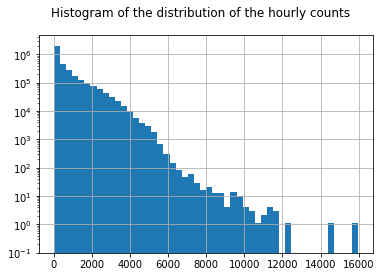

In [23]:
import pylab as pl
inputCols=df_pedcount.select('Hourly_Counts').collect()
x = [item[0] for item in inputCols]
x = pd.Series(x)
fig, ax = plt.subplots()
x.hist(ax=ax, bins=50, bottom=0.1)
ax.set_yscale('log')
pl.suptitle("Histogram of the distribution of the hourly counts")

**Plot Description**

The distribution is skewed to the right. This shows that the data is imbalanced as most of the hourly counts fall below 2000. In general, the frequency decreases as the hourly count increases. 

**Line-plot**

Plot line-plot to show the trend of the average daily count change by month

In [24]:
# Find total days in every month
year_mon = df_pedcount.groupBy("Year", "Month").agg(countDistinct("Mdate"))
month_day = year_mon.groupBy("Month").agg({'count(Mdate)':'sum'})
daily_count = df_pedcount.groupBy("Month").agg({'Hourly_Counts':'sum'})
# get new dataframes with average daily pedestrian count
df1 = daily_count\
    .join(month_day, "Month", "inner")\
    .withColumn("Average_daily_pedcount", (f.col("sum(Hourly_Counts)") / f.col("sum(count(Mdate))")))\
    .orderBy(month(to_date("Month", "MMMM")))

/home/student/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Month'>

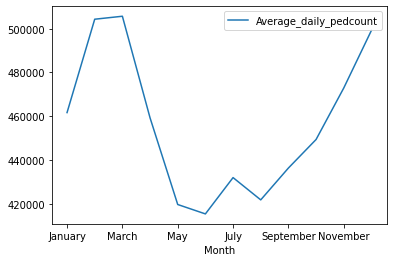

In [25]:
# convert to pandas and plot
pdf1 = df1.toPandas()
# gca stands for 'get current axis'
ax = plt.gca()
pdf1.plot(kind='line',x='Month',y='Average_daily_pedcount',ax=ax)

**Plot Description**

The average daily pedestrain counts for February, March and December are the highest among the months. The are a sharp drop from March to May. The pedestrain counts in May to August are relatively low compared to other months, and June has the lowest counts. The pedestrain count increases starting from August to December. 

#### 1.2) 4. Explore the data

**Plot 1: Time in a day vs pedestrain counts**

Correlation plots for the relationship between time in a day and the hourly pedestrain counts for different days in a week.

In [26]:
week_hour = df_pedcount.groupby("Time",'day').agg({'Hourly_Counts':'avg'}).select('Time','day','avg(Hourly_Counts)')

In [27]:
p_week = week_hour.select('*').toPandas()

Text(0, 0.5, 'Average Hourly Counts')

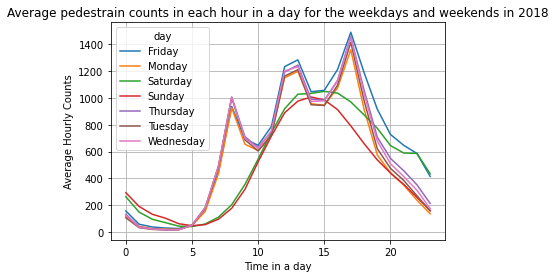

In [28]:
week_time = p_week.pivot(index = 'Time',columns = 'day', values = 'avg(Hourly_Counts)')
week_time.plot(title = 'Average pedestrain counts in each hour in a day for the weekdays and weekends in 2018')
ax = plt.gca()
ax.grid(True)
ax.set_xlabel("Time in a day")
ax.set_ylabel("Average Hourly Counts")

**Plot's description and discussion**

This plot is worth to present to the MelbourneGig company as the plot clearly shows the difference in traffic volume in a day and for every week. This is useful in telling the company the best and worst time for the performers to perform.

The average pedestrian traffic volume of the weekdays is higher than the weekends. There are three peak periods in a day for the weekdays i.e. around 7:30a.m., 12p.m. and 1p.m., and 5p.m. These hours are assumed to be the “go to work" hour, lunch hour, and “back from work" hour respectively. The volume of pedestrian is at the least from midnight until dawn i.e. 1a.m. to 5a.m. Unlike the weekdays, the trend lines of the weekends are much smoother as the weekends have only one peak in a day, that is from 1p.m. to 3p.m. Moreover, the pedestrian volume during the time between midnight and dawn is higher than the weekdays. 


**Plot 1: Time in a day vs pedestrain counts**

Correlation plots for the relationship between time in a day and the hourly pedestrain counts for different days in a week.

In [30]:
weekends = ["Saturday", "Sunday"]
df_pedcount1 = df_pedcount.withColumn("week",when((col("day").isin(weekends)), "weekend")\
              .otherwise('weekday'))

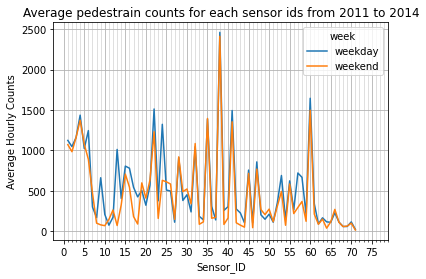

In [31]:
sen_year = df_pedcount1.groupby("Sensor_ID",'week').agg({'Hourly_Counts':'avg'})\
            .select('Sensor_ID','week','avg(Hourly_Counts)')\
            .orderBy("Sensor_ID", 'week')

sen_year = sen_year.select('*').toPandas()
sen_years = sen_year.pivot(index = 'Sensor_ID',columns = 'week', values = 'avg(Hourly_Counts)')
sen_years.plot(title = 'Average pedestrain counts for each sensor ids from 2011 to 2014')
ax = plt.gca()
ax.set_xlabel("Sensor_ID")
ax.set_ylabel("Average Hourly Counts")
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 80, 5)
minor_ticks = np.arange(0, 80, 1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.5)
ax.grid(which='major', alpha=1)

**Plot's description and discussion**

This plot is worth to present to the MelbourneGig company as the plot clearly shows the difference in traffic volume in every sensor id. This is useful in telling the company where are the good places for the performers to perform.

The average pedestrian traffic volume of Sensor 38 - Flinders St-Swanston St (West) is the highest. Sensor 4, 22, 41, 60 are also considered in the top 5 sensors with the most average pedestrain count in the Melbourne CBD. From the plot, we can see that most sensors have recorded more pedestrains in the weekdays than the weekends. Specifically, Sensor 15, 19, 26, 28, 32, 35, and 66 have higher pedestrain counts in the weekends. 

In addition, the pedestrain count trends for the weekdays and weekends are similar, with the exception of Sensor 9, 13, 16, 18, 24, 57, and 58. These sensors have big different in the pedestrain counts between the weekdays and weekends. From this information, we know that these places are crowded only in the weekdays, thus these places possible near to work places or school. 

## Feature extraction and ML training
### 2.1 Discuss the feature selection and prepare the feature columns
#### 2.1) 1. Perform a one-step time-series prediction

The model's prediction for the next hour count **(between 9:00am and midnight)** would be based on the previous pedestrain counts.


Select the useful features based on various metrics like:

**Basic Knowledge**:  <span style="color: green;">ID</span> are not selected because it is unique and will not affect the result. <span style="color: green;">Date_Time</span> and <span style="color: green;">Sensor_Name</span> are not selected because there are other variables that can represent them (i.e., <span style="color: green;">Month</span>, <span style="color: green;">Year</span>, <span style="color: green;">Mdate</span>, <span style="color: green;">Time</span>, and <span style="color: green;">Sensor_ID</span>).
        
**Statistical Method**: 

- Hypothesis Testing

All the independent variables are treating as categorical variable. Therefore, Chi-Square is used to carry out the hypothesis testing with the null and alternative hypothesis as below:

        a. H0: The attribute (i.e. year, month, date, dayofweek, time or sensor id) has no role to play in whether the pendestrain count exceeds 2000 (i.e. above threshold)
        b. H1: The attribute has a role to play in whether the pendestrain count exceeds 2000
        
The significant level is set at 0.05. As the variables year, month, Mdate, day, Time, and sensor id have p-values smaller than 0.05, the Null Hypothesis need to be rejected for these variables. This means, there is relationship between each of these variables and the above threshold attribute. The p-value of ID is larger than 0.05, therefore, do not reject the Null Hypothesis, meaning there is no relationship between the ID and the target value. Hence, columns to be used as features are:
        - Year
        - Month
        - Mdate
        - day
        - Time
        - Sensor_ID

In [32]:
#split for smaller data
(t4, t5) = df_pedcount.randomSplit([0.2, 0.8], seed=2020)
d = t4.toPandas()

#Testing the relationship
inde_var = ['Year', 'Month', 'Mdate', 'day', 'Time', 'Sensor_ID', 'ID']

for var in inde_var:
    chi_res = chi2_contingency(pd.crosstab(d['above_threshold'], d[var]))
    print(var,'>>','Degree of freedom: {}, p-value: {}'.format(chi_res[2], chi_res[1]))

Year >> Degree of freedom: 11, p-value: 0.0
Month >> Degree of freedom: 11, p-value: 7.299872228696009e-117
Mdate >> Degree of freedom: 30, p-value: 3.6735251270195022e-09
day >> Degree of freedom: 6, p-value: 0.0
Time >> Degree of freedom: 23, p-value: 0.0
Sensor_ID >> Degree of freedom: 70, p-value: 0.0
ID >> Degree of freedom: 688211, p-value: 0.4994332614805857


**Visualization**: 

- Seasonality

        a. By visualising the plot of average pedestrain counts in each hour in a day for the weekdays and weekends shown in section 1.2.4 above, we know that Hourly_Counts are dependent on the time in a day and the day in a week. The plot also shows daily seasonality.
        b. From the plot of Year vs Hourly Counts, there is no obvious seasonality but a constant (2009 - 2013), a period of increase trend (2014 - 2019), and a sharp drop (2020).

/home/student/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='period'>

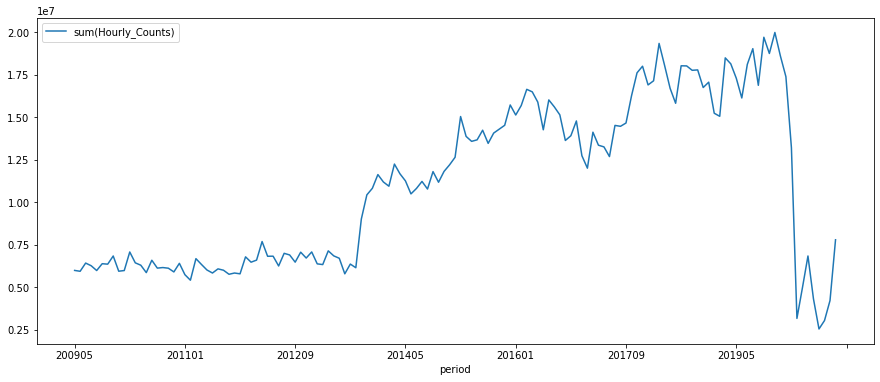

In [33]:
(train3, test3) = plt1.randomSplit([0.8, 0.2], seed=2020)
yrs1 = list(range(2009, 2021))
t1 = train3.filter(col('Year').isin(yrs1))\
        .select('Date_Time', 'Hourly_Counts')

#split
split_col = f.split(t1['Date_Time'], ' ')
split_t1 = t1.withColumn('Date', split_col.getItem(0))
split_coll = f.split(split_t1['Date'], '/')
split_t2 = split_t1.withColumn('mm', split_coll.getItem(0))
split_t2 = split_t2.withColumn('dd', split_coll.getItem(1))
split_t2 = split_t2.withColumn('yy', split_coll.getItem(2))

pdf_split = (
    split_t2.groupby('yy', 'mm').agg({'Hourly_Counts':'sum'})\
    .select(
        "yy",
        "mm",
        "sum(Hourly_Counts)",
    )
    .orderBy("yy", "mm")
    .toPandas()
)

#join
pdf_split["period"] = pdf_split["yy"] + pdf_split["mm"]

#plot
pdf_split.plot.line(x="period", y="sum(Hourly_Counts)", figsize=(15, 6))

        c. As shown in the plot below (time window between Jan 2018 and June 2018), if it is switched to the daily scale, the weekly seasonality pattern becomes evident, with increasing pedestrain across the weekdays and lower counts over the weekends.

/home/student/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='wday'>

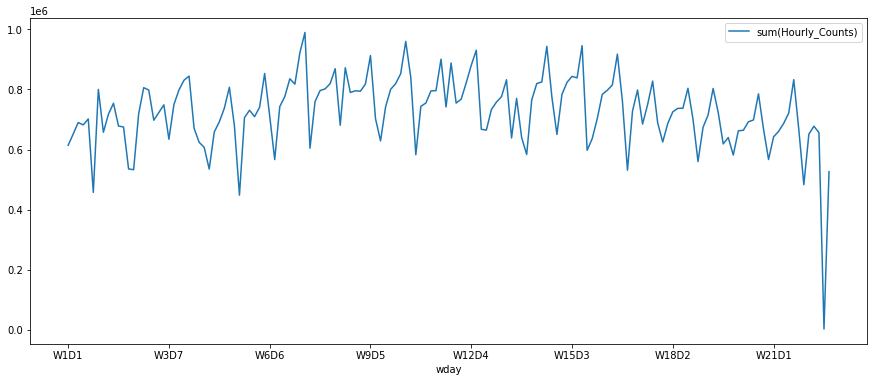

In [36]:
# select year 2019 and count week of year
date_range = ['2017-12-31', '2018-12-31']
fil_date = df_pedcount.where(col('Date_Time').between(*date_range))
w1 = Window.orderBy('Date_Time')
pop = fil_date.withColumn('datediff', f.datediff('Date_Time', f.first('Date_Time').over(w1))) \
      .withColumn('weeks', (f.col('datediff') / 7).cast('int') +1)

# filter the required period

dates = ['2017-12-31', '2018-05-31']
pop = pop.where(col('Date_Time').between(*dates))

# sum the counts
all_weeks = pop.groupBy("weeks","Day")\
           .agg({'Hourly_Counts':'sum'})

# convert day of week to number
all_weeks = all_weeks.withColumn("DayofWeek", \
              when(all_weeks["Day"] == 'Monday', 1).when(all_weeks["Day"] == 'Tuesday', 2)\
                                 .when(all_weeks["Day"] == 'Wednesday', 3)\
                                 .when(all_weeks["Day"] == 'Thursday', 4).when(all_weeks["Day"] == 'Friday', 5).when(all_weeks["Day"] == 'Saturday', 6).when(all_weeks["Day"] == 'Sunday', 7) )
all_weeks = all_weeks.drop('Day')

# calculate subtotal
counts = all_weeks.groupBy("weeks")\
        .agg({'sum(Hourly_Counts)':'sum'})         
counts = counts.withColumnRenamed('sum(sum(Hourly_Counts))', 'sum(Hourly_Counts)')  

counts = counts.withColumn('DayofWeek', f.lit('Subtotal'))
df3 = all_weeks.union(counts)
all_week = df3.orderBy(["weeks", "DayofWeek"])
all_week = all_week.filter(col('DayofWeek') != 'Subtotal').toPandas()
all_week[["weeks", "DayofWeek"]] = all_week[["weeks", "DayofWeek"]].astype(str)
all_week["wday"] =str('W') + all_week["weeks"] + str("D") + all_week["DayofWeek"]

#plot
all_week.plot.line(x="wday", y="sum(Hourly_Counts)", figsize=(15, 6))

        c. The monthly seasonality of the data is quite obvious as the pattern repeats across the years as shown in the plot below. Generally, there are falls in pedestrain counts every May, June and August rising again every February, July, and November. 

/home/student/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'Total Hourly Counts')

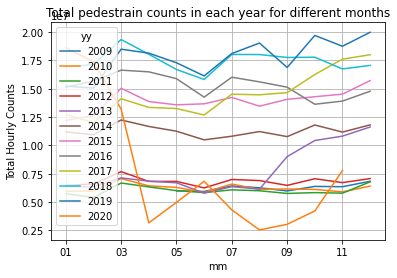

In [37]:
m_year1 = pdf_split.pivot(index = 'mm',columns = 'yy', values = 'sum(Hourly_Counts)')
m_year1.plot(title = 'Total pedestrain counts in each year for different months')
ax = plt.gca()
ax.grid(True)
ax.set_xlabel("mm")
ax.set_ylabel("Total Hourly Counts")

- Correlation

        a. The plot below shows that there is a positive correlation between the hourly count and the year where the correlation coefficient is 0.72, indicating that year and hourly count are quite strongly correlated. 

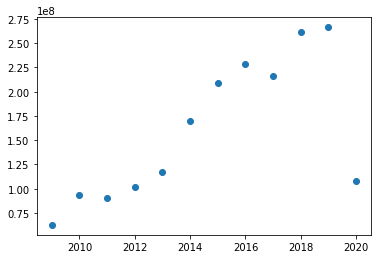

Correlation coeff: 0.7242219407382018


In [38]:
month_year = df_pedcount.groupby("Year").agg({'Hourly_Counts':'sum'}).select('Year','sum(Hourly_Counts)')
month_year = month_year.select('*').toPandas()
plt.scatter(x=month_year['Year'], y=month_year['sum(Hourly_Counts)'])
plt.show()

column_1 = month_year["Year"]
column_2 = month_year["sum(Hourly_Counts)"]
correlation = column_1.corr(column_2)
print("Correlation coeff:",correlation)

Based on the visualisation approach and applying domain knownledge on this time series data, both the secular trend and seasonality are important to forecast the pedestrain counts in the next quarter (Year 2019). Therefore, seasonality is not required to be removed in this use case. 

As the decision tree model and gbt model will considered the different in hourly count pattern on weekdays and weekends, it is sensible to set the day of week as dummy values using the `one-hot-encoding`. The <span style="color: green;">Year</span>, <span style="color: green;">Month</span>,<span style="color: green;">Mdate</span>, <span style="color: green;">Time</span> will be treated as ordinal vairables. This is because, removing the ordinality of these variabels would destroy the proximity measure and ordering property of these variables. For example, the actual distance two points of any year, month, day or time would be disregarded. 

To avoid fitting the 23 parameters of <span style="color: green;">Time</span> in addition to the model intercept, the <span style="color: green;">Time</span> can be modeled as continuous by trigonometric tramsformation, in which the hour of the day will be transform into sine and cosine.

#### 2.1) 2. Create columns for prediction

- Transformed time into sine and cosine with trigonometric transformation

In [39]:
import pyspark
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import math

def my_udf(val1):
    return math.sin(2*math.pi*val1/24)

udf_xhr = udf(my_udf, FloatType())

def my_udf2(val1):
    return math.cos(2*math.pi*val1/24)

udf_yhr = udf(my_udf2, FloatType())


In [40]:
df_pedcount = df_pedcount.withColumn('xhr', udf_xhr("Time"))
df_pedcount = df_pedcount.withColumn('yhr', udf_yhr("Time"))

### 2.2 Preparing Spark ML Transformers/Estimatorss for features, labels and models
#### 2.2) 1 Create transformers/estimators for columns assembling and model
Create Transformers/Estimators for transforming/assembling the selected columns
   
   a. StringIndexer
   
   <a class="anchor" name="string-indexer"></a>
<code>StringIndexer</code> encodes string columns as indices. It assigns a unique value to each category. We need to define the input column/columns name and the output column/columns name in which we want the results.

In [41]:
from pyspark.sql.functions import from_unixtime, unix_timestamp
df_pedcount = df_pedcount.withColumn("Month",from_unixtime(unix_timestamp(col("Month"),'MMMM'),'MM'))
from pyspark.sql.types import IntegerType
df_pedcount = df_pedcount.withColumn("Month", df_pedcount["Month"].cast(IntegerType()))

In [42]:
inputCols_num = ['Year', 'Mdate', 'Month', 'xhr', 'yhr']
inputCols_notnum = ['day', 'Sensor_ID']

In [43]:
# For binary classification
inputCols = inputCols_notnum
outputCols = [f'{x}_index' for x in inputCols_notnum]
stage_1 = StringIndexer(inputCols=inputCols, outputCols=outputCols,  handleInvalid = 'keep')

    b. One Hot Encoder (OHE)

`One hot encoding` is representation of categorical variables as binary vectors. It works in 2 steps:
1. The categorical variables are mapped as integer values
2. Each integer value is represented as binary vector

In [44]:
# For binary classification
inputCols_OHE = [x for x in outputCols]
outputCols_OHE = [f'{x}_vec' for x in inputCols]
stage_2 = OneHotEncoder(inputCols=inputCols_OHE,
                        outputCols=outputCols_OHE)

    c.VectorAssembler 

Finally, once we have transformed the data, we want to combine all the features into a single feature column to train the machine learning model. <code>VectorAssembler</code> combines the given list of columns to a <em>single vector</em> column.

In [45]:
#inputCols = outputCols_OHE
all_tgt = inputCols_num + outputCols_OHE
stage_3 = VectorAssembler(
    inputCols=all_tgt,
    outputCol="features")

Create ML model Estimators for Decision Tree and Gradient Boosted Tree model for each use case

In [46]:
# decision tree stores in dt.
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'above_threshold')

# gradient boosted tree model stores in gbt
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'above_threshold')


#### 2.2) 2. Pipelines for tranformers/estimators

In [47]:
# pipeline for decision tree
pipeline_dt = Pipeline(stages=[stage_1, stage_2,stage_3, dt])

# pipeline for decision tree
pipeline_gbt = Pipeline(stages=[stage_1, stage_2, stage_3, gbt])

pipeline = Pipeline(stages=[stage_1, stage_2])

#### 2.2) 3. Hyperparameters of decision tree classification
`maxDepth` in the **Decision Tree model** is a stopping criteria set in tuning process of the decision tree model. It represents the maximum depth of the tree. The larger the `maxDepth` (deeper the tree) the hihger the accuracy the model will be and more likely for the model to be overfitted. 

`maxBins` determines the total bins number used for splitting features. In Spark, however, workers have all the columns of the data, but only a subset of the rows. Thus, when communicating about which features and values to split on, it is vital make sure that all the model are working with the same split values, which get from the common discretization set up at training time. Each of the possible splitting point and the summary statistics for each feature are computed by every worker. The statistics information will then be summed together across the workers. In `MLlib`, `maxBins` is required to be sufficiently large so as to deal with the descritisation of the cateforical variables. 

MLlib requires maxBins to be large enough to handle the discretization of the categorical columns. The default value for maxBins is 32. As the maxBins increases, the continoues fearures of the data will be represented more accurately. However, that would also increase the possible splitting of continuos variable which will increase the computation time. 


### 2.3 Preparing the training data and testing data
#### 2.3) 1. Split the data for training (year 2014 to 2018 hours between 9:00am and midnight) and testing (year 2019 hours between 9:00am and midnight) purpose

In [48]:
# create training set
train2 = df_pedcount.filter((f.col('Year') > 2013) &\
                           (f.col('Year') < 2019) &\
                           (f.col('Time') >= 9))

In [49]:
test2 = df_pedcount.filter((f.col('Year') == 2019) &\
                          (f.col('Time') >= 9))

### 2.4 Training and evaluating models
#### Use case 1: Predict whether count would go above 2000 for the hours between 9:00am and midnight

2.4) 1. Build the binary classification models and perform predictions with binary label (0 and 1)

**Decision Tree Model**

In [50]:
# decision tree model
dtModel =pipeline_dt.fit(train2)
dtPredictions = dtModel.transform(test2)

**Gradient Boosted Tree Model**

In [51]:
# gbt model
gbtModel =pipeline_gbt.fit(train2)
gbtPredictions = gbtModel.transform(test2)

2.4) 1. Compute the AUC, accuracy, recall and precision for the above-threshold/below-threshold label 

In [52]:
# create a function for confusion matrix
def confus_matrix(data):
    FN = data.filter('prediction = 0 AND above_threshold = 1').count() 
    TN = data.filter('prediction = 0 AND above_threshold = 0').count()
    TP = data.filter('prediction = 1 AND above_threshold = 1').count()
    FP = data.filter('prediction = 1 AND above_threshold = 0').count()
    
    # calculate metrics by the confusion matrix
    accuracy = (TP + TN)/(TP+TN+FP+FN)# formula to find accuracy
    precision = TP/(TP+FP)# formula to find precision
    recall = TP/(TP+FN)# formula to find recall
    f1 = 2/((1/recall)+(1/precision))# formula to find F1-score
    # Display the various metrics calculated above
    print("Accuracy = %g " % accuracy)
    print("Precision = %g " % precision)
    print("Recall = %g " % recall)
    print("f1 = %g " % f1)
    
    return accuracy,precision,recall,f1  

- Confusion matrix for decision tree

In [53]:
# show confusion matrix for decision tree
dtPredictions.groupBy('above_threshold', 'prediction').count().show()

+---------------+----------+------+
|above_threshold|prediction| count|
+---------------+----------+------+
|              1|       0.0| 21595|
|              0|       0.0|249244|
|              1|       1.0|  9446|
|              0|       1.0|  5247|
+---------------+----------+------+



In [54]:
confus_matrix(dtPredictions)

Accuracy = 0.905993 
Precision = 0.642891 
Recall = 0.304307 
f1 = 0.413084 


(0.9059930235490242,
 0.6428911726672565,
 0.3043072065977256,
 0.41308435737088384)

- Confusion matrix for gradient boosted tree

In [56]:
# show confusion matrix for gradient boosted tree
gbtPredictions.groupBy('above_threshold', 'prediction').count().show()

+---------------+----------+------+
|above_threshold|prediction| count|
+---------------+----------+------+
|              1|       0.0| 14205|
|              0|       0.0|251231|
|              1|       1.0| 16836|
|              0|       1.0|  3260|
+---------------+----------+------+



In [57]:
confus_matrix(gbtPredictions)

Accuracy = 0.938833 
Precision = 0.837779 
Recall = 0.542379 
f1 = 0.658466 


(0.9388334757575333,
 0.8377786624203821,
 0.5423794336522664,
 0.6584664724172321)

- Discuss which is the better model, and persist the better model.

Accuracy is normally suitable to be used in measuring the model performance of binary multiclass classification. However, The data set is imbalanced, and all the data points are classified as the majority class data points (i.e., hourly counts lower than 2000), causing high accuracy of the model. Therefore, although the models are relatively accurate, it will be not valuable as accuracy is not so reliable in measuring the model performance for this data set. 
F-score is most suitable to measure the model performance because it is a score that maintains a balance between the precision and recall of the model, where precision will summarise the fraction of the true positive class to the positive class and recall measure how accurate the positive class was predicted.
For this case, it is important to have for the model that is good at precision and recall. For example, it is vital to be sure that the pedestrian counts at the specific location is actually high i.e., >2000 (precision) for the performers, and to record as many locations with high pedestrian counts in the CBD of Melbourne as possible (recall). 

According to the AUC results, the F1 score is higher in the Gradient Boosted Tree (GBT) Model, thus a better model.  Gradient-Boosted Trees (GBTs) are ensembles of decision trees. GBTs iteratively train decision trees in order to minimize a loss function. Like decision trees, GBTs handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.


- Model Persistance

After the **bestModel** has been selected, the model will be saved and loaded again. 

In [66]:
from pyspark.ml import PipelineModel
#Saves the model to the filesystem
gbtModel.save('gbt_best_model')

#Loading the Pipeline Model From the filesystem
pipelineModel = PipelineModel.load('gbt_best_model')

print(pipelineModel.stages[-1]._java_obj.paramMap())

Py4JJavaError: An error occurred while calling o1831.save.
: java.io.IOException: Path gbt_best_model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:176)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:171)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)


2.4) 3. Leaf node splitting criteria and the top-3 features

- Extract the `if-then-else` rules learned by the decision tree. In which it shows the leaf node splitting criteria. 

In [65]:
model_dt = dtModel.stages[-1]
print(model_dt.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e8a189156cbe, depth=5, numNodes=41, numClasses=2, numFeatures=70
  If (feature 54 in {1.0})
   If (feature 4 <= 0.6035533845424652)
    If (feature 3 <= 0.6035533845424652)
     Predict: 1.0
    Else (feature 3 > 0.6035533845424652)
     If (feature 6 in {1.0})
      Predict: 0.0
     Else (feature 6 not in {1.0})
      If (feature 5 in {1.0})
       Predict: 0.0
      Else (feature 5 not in {1.0})
       Predict: 1.0
   Else (feature 4 > 0.6035533845424652)
    If (feature 7 in {1.0})
     If (feature 1 <= 1.5)
      If (feature 2 <= 1.5)
       Predict: 0.0
      Else (feature 2 > 1.5)
       Predict: 1.0
     Else (feature 1 > 1.5)
      Predict: 1.0
    Else (feature 7 not in {1.0})
     If (feature 5 in {1.0})
      Predict: 1.0
     Else (feature 5 not in {1.0})
      Predict: 0.0
  Else (feature 54 not in {1.0})
   If (feature 40 in {1.0})
    If (feature 4 <= -9.184850732644269E-17)
     If (feature 3 <= 0.379409521818

- Top-3 features with each corresponding feature
importance

In [67]:
# function to extract feature importance
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [69]:
top3 = ExtractFeatureImp(dtModel.stages[-1].featureImportances, dtPredictions, "features")

sensor_id = top3[top3['name'].str.contains("Sensor_ID", na=False)]
sid_score = sum(sensor_id['score'].values[0:])

time = top3[top3['name'].str.contains("hr", na=False)]
time_score = sum(time['score'].values[0:])

day = top3[top3['name'].str.contains("day", na=False)]
day_score = sum(day['score'].values[0:])

labels = [['Sensor_ID'], ['Time'], ['day']]
features = [sid_score, time_score, day_score]

dd = [(labels[i][0], Vectors.dense(features[i])) for i in range(len(labels))]
df_top3 = spark.createDataFrame(sc.parallelize(dd),schema=["label", "features"])

df_top3.show()

+---------+--------------------+
|    label|            features|
+---------+--------------------+
|Sensor_ID| [0.684151052186981]|
|     Time|[0.3036723722249763]|
|      day|[0.01213789254334...|
+---------+--------------------+



- Description the result

Accroding the result, the 3 most important featueres for the street art performers to know are the Sensor_ID, Time and day. This tells the performers to always consider the location of the performance first, follow by the Time and then day. Knowing the three features anable them to plan their performance venue and date time so that they can reach more audiences. 

2.4) 4. Improve the prediction

**K-fold cross validation and hyperparameter tuning**

The prediction for use case 1 can be improved by cross validation and hyperparameter tuning.

Hyperparameter tuning can be done by choosing a set of optimal hyperparameters for a learning algorithm. One popular approach is to create a grid of hyper-parameters we want to optimze with the values we want to try out.

The training set is not suitable to be used to determine the optimal hyperparameter values as this may cause the model to be overfit.  Therefore, a validation data set is to be created to try out all the possible combination of the hyperparameters and evaluates the best model performance with the optimal hyperparameter values. When we use this with the <code>CrossValidator (K-Fold)</code>, for each fold (i.e. the train/test split), it tries out all the possible combination of the hyper-parameters and evaluates the performance of each instance. Finally, based on the evaluaton, it gives us the best model i.e. the best combination of hyperparameters to use.

**Implementation**

Import `spark.ml` to provide a set of high-level APIs that is able to help the users to create and tune machine learning pipelines.

In Spark, we can use <code>ParamGridBuilder</code> to define the hyperparameters for any estimator. Since, the model needs to be evaluated at every parameter combination, we need to also define an <code>Evaluator</code>.

For `Decision Tree` model, take `maxBins` and `maxDepth` as the two hyperparamters.Build a grid specifying all the parameters and their values we want to test our model with. We are assigning a series of values for the hyperparameters <code>maxDepth</code> and <code>maxBins</code>. For `Gradient Boosted Tree` model, the parameters for tuning are `maxIter` and `maxDepth`.

Lastly, the best model and the optimum parameters selected from the Cross Validation. 

Code snippet on how to implement K-fold cross validation and hyperparameter tuning is shown as below:

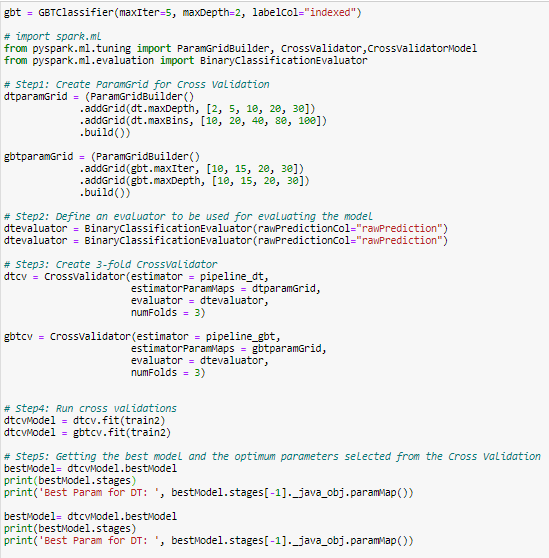

**Handling Outliers**

The unwanted presence of missing and outlier values in the training data often reduces the accuracy of a model or leads to a biased model. It will also leads to inaccurate predictions when the behavior and relationship with other variables are analysed incorrecgtly. So, it is important to handle the outliers carefully.

The outliers can either be deleted, imputed with mean, median or mode or treated as separate values. For this use case, the outliers will be removed using the standard diviation method.

**Implementation**

First, calculate the mean and standard deviation of the pedestrain hourly counts, then calculate the cut-off to identify the outliers that are 3 standard deviations exceeded the mean.

Then filter out the hourly counts that are not within the defined limits and use this filtered dataset to train the model using `Decision Tree` model as an example. 

The codes are shown as below:

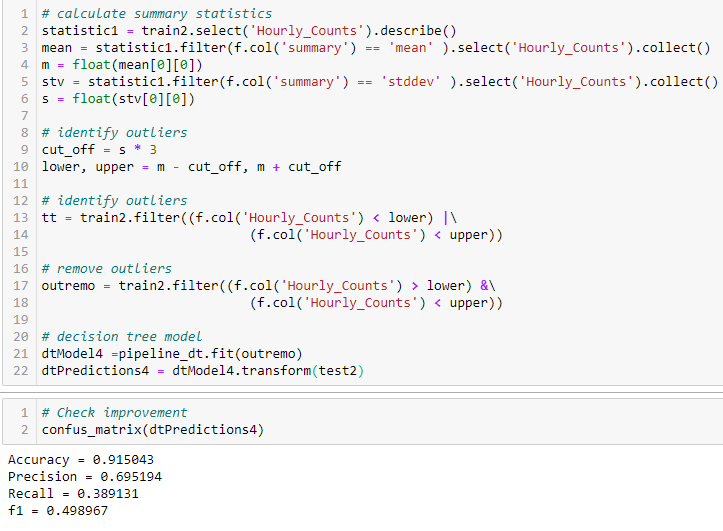

The performance of the `Decision Tree` model has improved after the removal of outliers.

#### Use case 2: Predict the possible count for the hours between 9:00am and midnight


Build the regression models, use the column “Hourly_Count” as label

2.4) 5. Train the models on the cache training data from 2.3

In [70]:
train2 = train2.cache()

In [71]:
# decision tree stores in dt.
dt2 = DecisionTreeRegressor(featuresCol = 'features',labelCol = 'Hourly_Counts',  maxDepth = 10)

# dradient boosted tree model stores in gbt
gbt2 = GBTRegressor(featuresCol="features",labelCol = 'Hourly_Counts', maxIter=10)


In [72]:
# pipeline for decision tree
pipeline_dt2 = Pipeline(stages=[stage_1, stage_2, stage_3, dt2])

# pipeline for decision tree
pipeline_gbt2 = Pipeline(stages=[stage_1, stage_2, stage_3, gbt2])

In [73]:
# decision tree model
dtModel2 =pipeline_dt2.fit(train2)
dtPredictions2 = dtModel2.transform(test2)#WRITE CODE to get predictions from the test data
dtPredictions2.select("features", "Hourly_Counts", "prediction")

DataFrame[features: vector, Hourly_Counts: int, prediction: double]

In [74]:
#WRITE CODE: Write the Predictions for test data and display the predictions
gbtModel2 =pipeline_gbt2.fit(train2)
gbtPredictions2 = gbtModel2.transform(test2)#WRITE CODE to get predictions from the test data
gbtPredictions2.select("features", "Hourly_Counts", "prediction")

DataFrame[features: vector, Hourly_Counts: int, prediction: double]

2.4) 6. Compute the RMSE and R-square

**R-square**

In [75]:
# Compute the R-square (decision tree)
dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Hourly_Counts",metricName="r2")
print("R Squared (R2) on test data = %g" % dt_evaluator.evaluate(dtPredictions2))

R Squared (R2) on test data = 0.428004


In [76]:
# Compute the R-square (gradient boosted tree)
gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Hourly_Counts",metricName="r2")
print("R Squared (R2) on test data = %g" % gbt_evaluator.evaluate(gbtPredictions2))

R Squared (R2) on test data = 0.48773


**RMSE**

In [79]:
# In Python
#from pyspark.ml.evaluation import RegressionEvaluator
regressionEvaluator = RegressionEvaluator(
 predictionCol="prediction",
 labelCol="Hourly_Counts",
 metricName="rmse")
rmse = regressionEvaluator.evaluate(dtPredictions2)
print(f"dt RMSE is {rmse:.1f}")


dt RMSE is 660.7


In [80]:
# In Python
#from pyspark.ml.evaluation import RegressionEvaluator
regressionEvaluator = RegressionEvaluator(
 predictionCol="prediction",
 labelCol="Hourly_Counts",
 metricName="rmse")
rmse = regressionEvaluator.evaluate(gbtPredictions2)
print(f"gbt RMSE is {rmse:.1f}")


gbt RMSE is 625.3


The GBT model is better as it has lower RMSE and R-square that is closer to 1. The GBT model with lower RMSE have predicted values that are closer to the observed data. Its R-square that is closer to 1 also shows that there are more observed data fitted into the regression line. 

In [85]:
#Saves the model to the filesystem
gbtModel2.save('gbt_regression_model')

#Loading the Pipeline Model From the filesystem
from pyspark.ml import PipelineModel
pipelineModel1 = PipelineModel.load('gbt_regression_model')

print(pipelineModel1.stages[-1]._java_obj.paramMap())

{
	GBTRegressor_a7d25bf0d294-featuresCol: features,
	GBTRegressor_a7d25bf0d294-labelCol: Hourly_Counts,
	GBTRegressor_a7d25bf0d294-maxIter: 10
}


## 3. Knowlegde Sharing
### 2.1 Observed jobs when training the KMeans clustering mdoel
Running KMeans clustering model code

In [86]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
customer_df = spark.createDataFrame([
(0,19,15,39),
(0,21,15,81),
(1,20,16,6),
(1,23,16,77),
(1,31,17,40),
(1,22,17,76),
(1,35,18,6),
(1,23,18,94),
(0,64,19,3),
(1,30,19,72),
(0,67,19,14),
(1,35,19,99),
(1,58,20,15)],
['gender', 'age', 'annual_income', 'spending_score'])
assembler = VectorAssembler(
inputCols=['gender', 'age', 'annual_income', 'spending_score'],
outputCol='features')
kmeans = KMeans(k=8).fit(assembler.transform(customer_df))

Screenshot from Spark UI for running a simple KMeans model. From the Spark UI, there are 10 jobs recorded when traing the KMeans clustering model from the above code. 

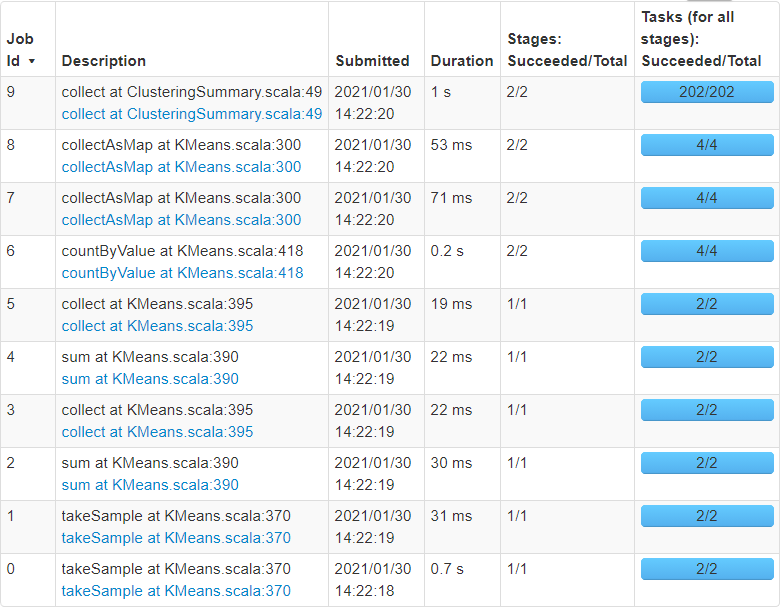

### 2.1 Observed jobs when training the KMeans clustering mdoel

The implementation of of KMeans clustering in the given case has adopted data parallelism. As shown in the spark UI, the first jobs observed are creating parallelism for the data set. In this case, there are 2 processors working. Each processor will be working independently to create 4 clusters based on the data partition. As shown in the spark UI job destription, the data is pratitioned to each other in each processor. Each processor will run kmeans locally on the data the have. At the end of each iteration, the global information is collected about the sum and count for each cluster within the processor. The sum and count of the data points are required to calculate the new mean value/centriod. The sum and count steps will only exist in data parallelism. As a result from this itteration and at the end of the KMean training, there will be 4 clusters collected. Also, the data does not move among the processors in data parallelism, the data only move across the clusters.

This training does not adopt result parallelism because, in a result parallelism, each processor will work on a cluster basis. At the begining, only 1 cluster will be assigned to 1 processor. 4 processors will be required to carry out result parallelism. During the iteration, there will be data moving among the processors based on the centroid. Global information such as sum and count are therefore not required as 1 processor only work on 1 cluster. 